In [30]:
!python -m spacy download en_core_web_sm
!python -m spacy download fr_core_news_sm

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connection.py", line 160, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "/opt/conda/lib/python3.7/site-packages/urllib3/util/connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "/opt/conda/lib/python3.7/socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno -3] Temporary failure in name resolution

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 677, in urlopen
    chunked=chunked,
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpool.py", line 381, in _make_request
    self._validate_conn(conn)
  File "/opt/conda/lib/python3.7/site-packages/urllib3/connectionpo

In [18]:
import os
import re
import time
import math
import random
import unicodedata

import numpy as np
import pandas as pd

from tqdm import tqdm

import spacy

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [19]:
SEED = 28

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [20]:
data_df = pd.read_csv('/kaggle/input/data-final/fra.txt', sep='\t', usecols=[0, 1])
data_df.columns = ['en', 'fr']
data_df.head()

,en,fr
0,Go.,Marche.
1,Go.,En route !
2,Go.,Bouge !
3,Hi.,Salut !
4,Hi.,Salut.


In [21]:
data_df.shape

(232735, 2)

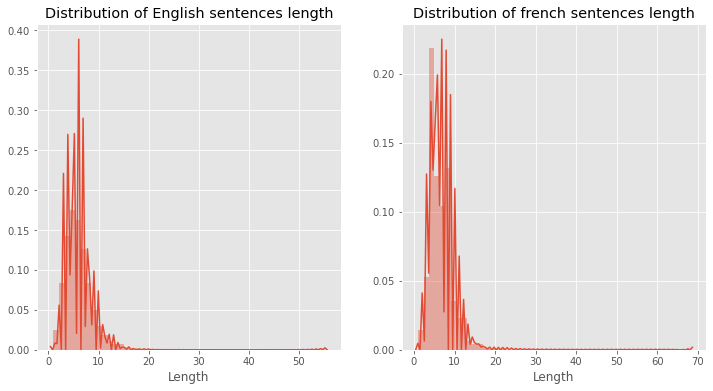

In [22]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(data_df['en'].str.split().apply(len))
plt.title('Distribution of English sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(data_df['fr'].str.split().apply(len))
plt.title('Distribution of french sentences length')
plt.xlabel('Length')
plt.show()

In [23]:
seq_len_en = 20
seq_len_de = 20

In [24]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, shuffle=True, random_state=28)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape)
print(valid_df.shape)

(209461, 2)
(23274, 2)


In [25]:
for i in range(len(train_df)-5, len(train_df)):
    print(f'ENGLISH:\n{train_df.iloc[i]["en"]},\nFrench:\n{train_df.iloc[i]["fr"]}\n{"="*92}')

ENGLISH:
I thought this was important.,
French:
Je pensais que c'était important.
ENGLISH:
You are a good person.,
French:
Vous êtes un mec bien.
ENGLISH:
I can't bend my right arm.,
French:
Je n'arrive pas à plier mon bras droit.
ENGLISH:
Tom got caught trying to steal a bracelet.,
French:
Tom s'est fait prendre en pleine tentative de vol d'un bracelet.
ENGLISH:
I'm not your friend.,
French:
Je ne suis pas votre ami.


In [26]:
class Vocabulary:
    def __init__(self, freq_threshold=2, language='en_core_web_sm', preprocessor=None, reverse=False):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.tokenizer = spacy.load(language)
        self.freq_threshold = freq_threshold
        self.preprocessor = preprocessor
        self.reverse = reverse
        

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        if self.reverse:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)][::-1]
        else:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = len(self.itos)
        for sentence in sentence_list:
            if self.preprocessor:
                sentence = self.preprocessor(sentence)
            for word in self.tokenize(sentence):
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 1
                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)
        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

In [27]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    return w

In [ ]:
%%time
freq_threshold = 2
en_vocab = Vocabulary(freq_threshold=freq_threshold, language="en_core_web_sm", preprocessor=preprocess_sentence, reverse=False)
fr_vocab = Vocabulary(freq_threshold=freq_threshold, language="fr_core_news_sm", preprocessor=preprocess_sentence, reverse=True)

en_vocab.build_vocabulary(train_df["en"].tolist())
fr_vocab.build_vocabulary(train_df["fr"].tolist())

In [ ]:
class CustomTranslationDataset(Dataset):    
    def __init__(self, df, en_vocab, fr_vocab):
        super().__init__()
        self.df = df
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        
    def __len__(self):
        return len(self.df)
    
    def _get_numericalized(self, sentence, vocab):
        """Numericalize given text using prebuilt vocab."""
        numericalized = [vocab.stoi["<sos>"]]
        numericalized.extend(vocab.numericalize(sentence))
        numericalized.append(vocab.stoi["<eos>"])
        return numericalized

    def __getitem__(self, index):
        en_numericalized = self._get_numericalized(self.df.iloc[index]["en"], self.en_vocab)
        fr_numericalized = self._get_numericalized(self.df.iloc[index]["fr"], self.fr_vocab)

        return torch.tensor(fr_numericalized), torch.tensor(en_numericalized)

In [ ]:
class CustomCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        src = [item[0] for item in batch]
        src = pad_sequence(src, batch_first=False, padding_value=self.pad_idx)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return src, targets

In [ ]:
BATCH_SIZE = 128

# Define dataset and dataloader
train_dataset = CustomTranslationDataset(train_df, en_vocab, fr_vocab)
valid_dataset = CustomTranslationDataset(valid_df, en_vocab, fr_vocab)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)

In [ ]:
fun_fr = np.vectorize(lambda x: fr_vocab.itos[x])
fun_en = np.vectorize(lambda x: en_vocab.itos[x])

In [ ]:
print(f"Unique tokens in source (de) vocabulary: {len(fr_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

## Modeling

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hidden_dim, n_layers, bidirectional=True, dropout=0.0 if n_layers==1 else dropout)
        self.fc = nn.Linear(2*hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, hidden_state = self.gru(x)
        hidden_state = torch.tanh(self.fc(torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)))
        return outputs, hidden_state

class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(3*hidden_dim, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)
    
    def forward(self, hidden_state, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        hidden_state = hidden_state.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        energy = torch.tanh(self.attention(torch.cat((hidden_state, encoder_outputs), dim = 2)))    
        attention = self.v(energy).squeeze(2)       
        return F.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, attention, dropout=0.2):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.attention = attention
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim+(hidden_dim*2), hidden_dim, n_layers, dropout=0.0 if n_layers==1 else dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim*3 + emb_dim, output_dim)
    
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)        
        embedded = self.dropout(self.embedding(input))               
        a = self.attention(hidden, encoder_outputs)        
        a = a.unsqueeze(1)        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)            
        weighted = torch.bmm(a, encoder_outputs)            
        weighted = weighted.permute(1, 0, 2)        
        rnn_input = torch.cat((embedded, weighted), dim = 2)               
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        assert (output == hidden).all()  
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)    
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        return prediction, hidden.squeeze(0)

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        assert self.encoder.hidden_dim == decoder.hidden_dim
        assert self.encoder.n_layers == decoder.n_layers
    
    def forward(self, x, y, teacher_forcing_ratio=0.75):
        
        target_len = y.shape[0]
        batch_size = y.shape[1]
        target_vocab_size = self.decoder.output_dim  # Output dim
        
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        encoder_outputs, hidden_state = self.encoder(x)
        input = y[0,:]
        # Decode the encoded vector using decoder
        for t in range(1, target_len):
            output, hidden_state = self.decoder(input, hidden_state, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            pred = output.argmax(1)
            input = y[t] if teacher_force else pred
        return outputs

In [ ]:
# Initialize all models
input_dim = len(fr_vocab)
output_dim = len(en_vocab)
emb_dim = 256
hidden_dim = 512
n_layers = 1
dropout = 0.5

attention = Attention(hidden_dim)
encoder = Encoder(input_dim, emb_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(output_dim, emb_dim, hidden_dim, n_layers, attention, dropout)
model = EncoderDecoder(encoder, decoder).to(device)

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.stoi["<pad>"])

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()
        
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    model.eval()    
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def inference(model, sentence):
    model.eval()
    result, attentions = [], []

    with torch.no_grad():
        sentence = sentence.to(device)
        
        encoder_outputs, hidden_state = model.encoder(sentence)

        inp = torch.tensor([en_vocab.stoi["<sos>"]]).to(device)
        for t in range(1, seq_len_en):
            attention = model.decoder.attention(hidden_state, encoder_outputs)
            output, hidden_state = model.decoder(inp, hidden_state, encoder_outputs)
            pred = output.argmax(1)
            if pred == en_vocab.stoi["<eos>"]:
                break
            result.append(en_vocab.itos[pred.item()])
            inp = pred
            attentions.append(attention.cpu().detach().numpy().ravel())

    return " ".join(result), attentions

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
for sample_batch in valid_loader:
    break

In [ ]:
import matplotlib.pyplot as plt

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

# Listes pour stocker les pertes
train_losses = []
valid_losses = []

sample_source = ' '.join([word for word in fun_fr(sample_batch[0][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])
sample_target = ' '.join([word for word in fun_en(sample_batch[1][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])

for epoch in range(N_EPOCHS):
    start_time = time.time()
    # Entraînement et évaluation
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    # Stocker les pertes pour le plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    # Sauvegarde du meilleur modèle
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    # Affichage des informations
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Sample Source: {sample_source}')
    print(f'\t Sample Target: {sample_target}')
    print(f'\t Generated: {inference(model, sample_batch[0][:, 101].reshape(-1, 1))[0]}\n')

# Plot des courbes de perte
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, N_EPOCHS + 1), valid_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the best model.
model_path = "./best_model.pt"
model.load_state_dict(torch.load(model_path))

## Results

In [ ]:
for idx in range(20):
    print(f'ACTUAL FRENCH: {" ".join([word for word in fun_fr(sample_batch[0][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'ACTUAL: ENGLISH: {" ".join([word for word in fun_en(sample_batch[1][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'GENERATED BY MODEL: {inference(model, sample_batch[0][:, idx].reshape(-1, 1))[0]}')
    print("="*92)

## Attention plots

Attention plot shows the amount of attention paid by the model to the source sequence words at the time of translation of each of the target word.

In [ ]:
def plot_attention_map(sentence):
    sentence = sentence.reshape(-1, 1)
    translated, attentions = inference(model, sentence)
    sentence = sentence.cpu().detach().numpy().ravel()
    sent_len = len(sentence[sentence != 0])
    
    fig, ax = plt.subplots(1, 1)
    fig.set_figheight(8)
    fig.set_figwidth(8)
    ax.imshow(np.array(attentions)[:, :sent_len], cmap='hot', interpolation='nearest')
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(['']+[word for word in fun_fr(sentence) if word not in ["<pad>"]], rotation=45)
    ax.set_yticklabels(['']+translated.split())

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.grid(False)
    plt.show()

In [ ]:
plot_attention_map(sample_batch[0][:, 0])

In [ ]:
plot_attention_map(sample_batch[0][:, 1])

In [ ]:
plot_attention_map(sample_batch[0][:, 15])

In [ ]:
plot_attention_map(sample_batch[0][:, 19])

In [ ]:
plot_attention_map(sample_batch[0][:, 2])